<a href="https://colab.research.google.com/github/warriors8970/Gen-AI/blob/main/Image%20Generation/Diffusion%20Models/diffusion_model_1/diffusion_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

# Helper functions

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
  """ Shows x images in a grid
      x - Batch of images """
  x = x*0.5 +0.5 # Scales down the image pixel values in the range (-1,1) to (0,1)
  grid = torchvision.utils.make_grid(x) # arrange the images into grid
  grid_im = grid.detach().cpu() # detach from gpu and move to cpu
  grid_im = grid_im.permute(1,2,0).clip(0,1) # changes (C, H, W) to (H,W,C) and clip the pixel values in range(0,1)
  grid_im = grid_im * 255 # brings the pixel values to 8 bit
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
  # convert tensor to numpy array and then to PIL image
  return grid_im

def make_grid(images, size = 128):
  """ Stack images together for easy viewing """
  output_im = Image.new("RGB", (size * len(images), size))
  for i, im in enumerate(images):
    output_im.paste(im.resize((size,size)), (i*size, 0))

  return output_im


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Model 1: DreamBooth
Testing out one random diffusion model

In [ ]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/nikeardilla"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

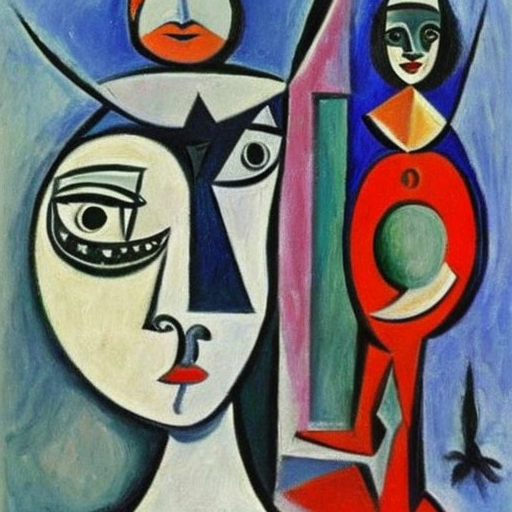

In [ ]:
prompt = "oil painting by picasso"
image = pipe(prompt, num_inference_steps =50, guidance_scale=7.5).images[0]
image

# Training Pipeline
``` Custom pipeline to train our images```
1. **Pipeline**: a series of functions to help our model to generate images
2. **Models**: architecture for diffusion models - UNet
3. **Schedulers**: Generate image from noise

In [ ]:
pipelines = [
    {'Pipeline': 'a series of functions to help our model to generate images'},
    {'Models': 'architecture for diffusion models - UNet'},
    {'Schedulers': 'Generate image from noise' }
]
pipelines

[{'Pipeline': 'a series of functions to help our model to generate images'},
 {'Models': 'architecture for diffusion models - UNet'},
 {'Schedulers': 'Generate image from noise'}]

In [ ]:
from diffusers import DDPMPipeline

butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)
# This is a custom pipeline made with butterfly images

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

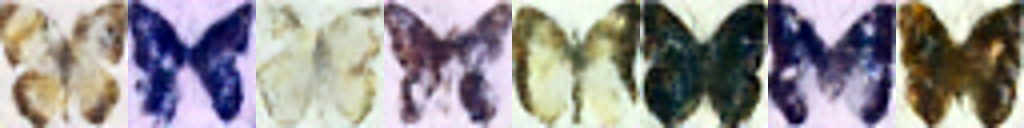

In [ ]:
images = butterfly_pipeline(batch_size=8).images
make_grid(images)

## Downloading custom Dataset

### Preprocessing
- Resize the image
- Data agumentation
- convert the data to tensor using `ToTensor()`
- Normalize the image using `Normalize()`

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split='train')

image_size = 32

batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), # Resize image
        transforms.RandomHorizontalFlip(), # Data agumentation
        transforms.ToTensor(), # Convert to tensor
        transforms.Normalize([0.5],[0.5]) # map to (-1,1)
    ]
)

def transform(examples):
  images =[preprocess(image.convert("RGB")) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
import os
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    dataset = dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = os.cpu_count()
)

In [ ]:
len(train_dataloader)

16

#### Visualizing our data

X shape: torch.Size([8, 3, 32, 32])


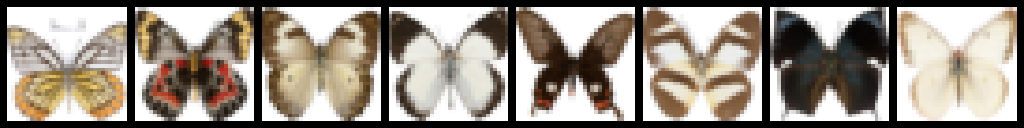

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 128, 128), resample = Image.NEAREST)

### Defining Scheduler
``` These noising are done at different timestamps```
- Add noise to image and feed it to the model
- Iteratively remove noise from the images

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps = 1000)

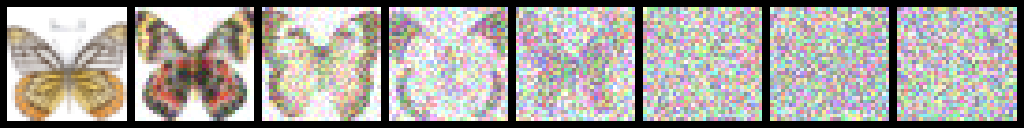

In [ ]:
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.rand_like(xb) # change a little bit in the noises
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
show_images(noisy_xb).resize((8*128,128), resample = Image.NEAREST)

In [ ]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

In [ ]:
xb0 = xb[0]
xb0 = xb0.detach().cpu().numpy()

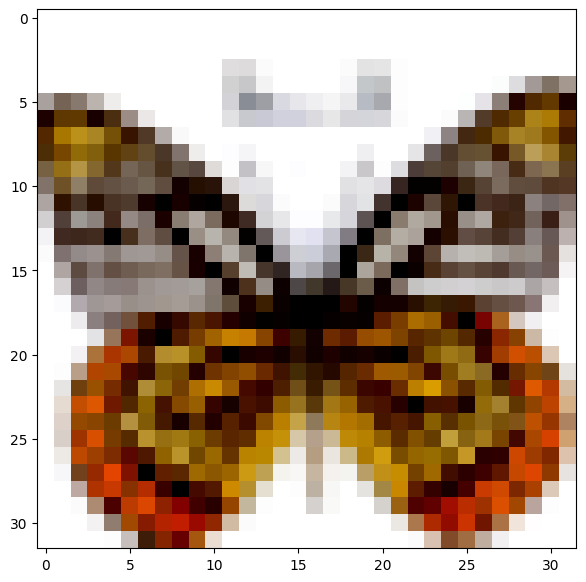

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(xb0, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

In [ ]:
xb0.shape

(3, 32, 32)

In [ ]:
noise.shape

torch.Size([8, 3, 32, 32])

In [ ]:
noise0 = noise[0]

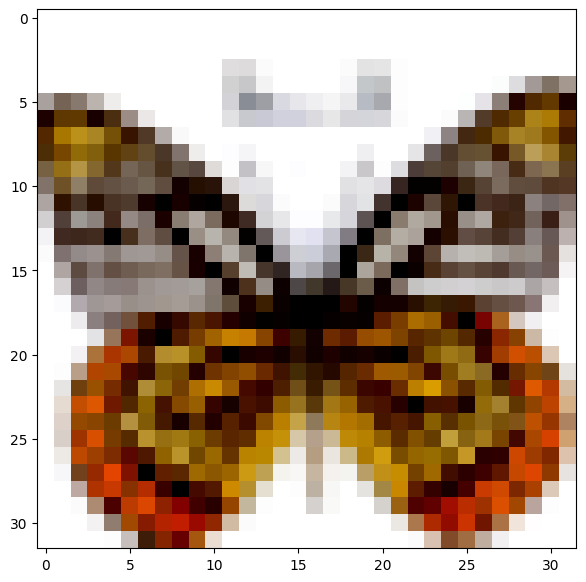

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(xb0, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

In [ ]:
print(noisy_xb.shape)
noisy_xb_3 = noisy_xb[3]

noisy_xb_3 = noisy_xb_3.detach().cpu().numpy()

torch.Size([8, 3, 32, 32])


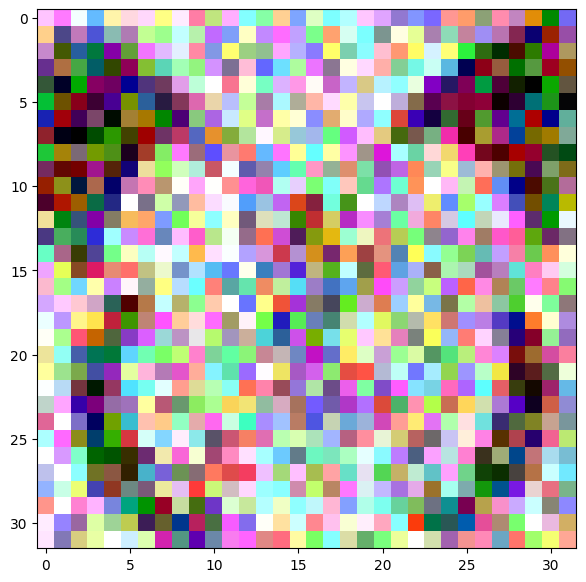

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(noisy_xb_3, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

# Creating the model
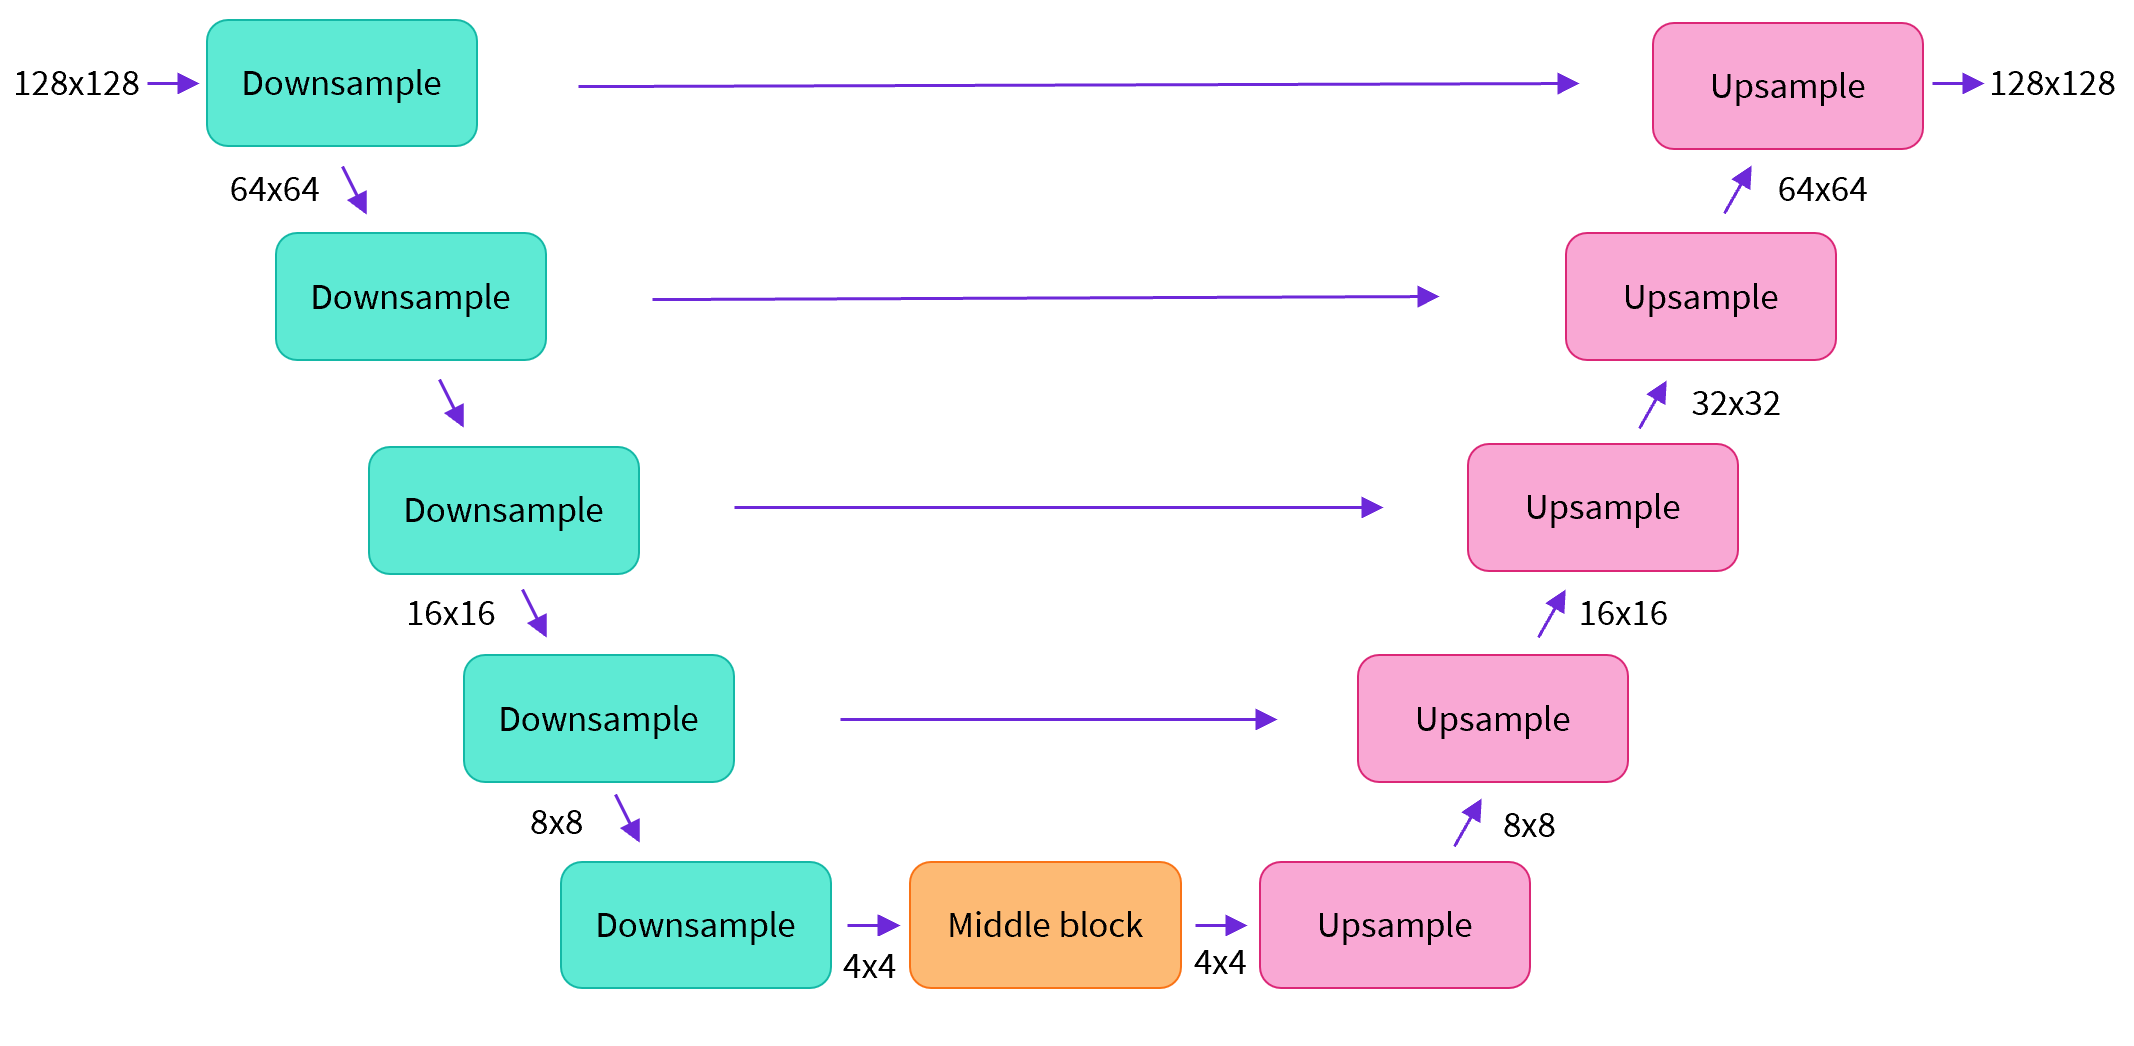
This is U-Net model(a variation of it)

In [ ]:
from diffusers import UNet2DModel

model =UNet2DModel(
    sample_size = image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block= 2,
    block_out_channels=(64,128,128,256),
    down_block_types = (
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D", # downsampling blovk with spatial self attention
        "AttnDownBlock2D",
    ),
    up_block_types= (
        "AttnUpBlock2D", # upsampling block with spatial self attention
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),

)
model.to(device);

In [ ]:
with torch.no_grad():
  model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

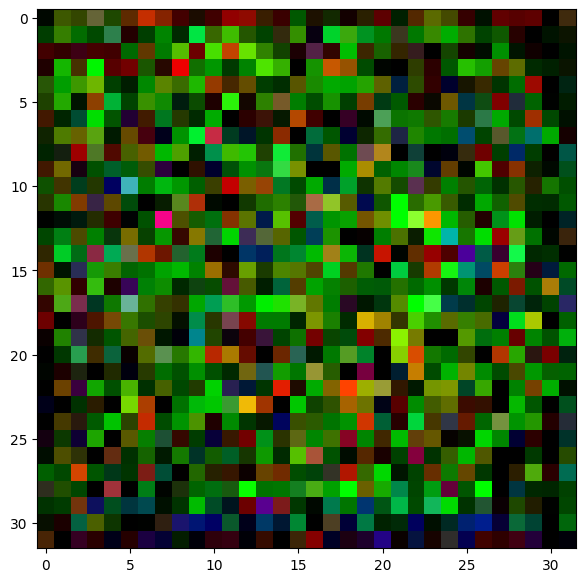

In [ ]:
# No data is fed into the model, so it randomly predicts
model_prediction_7 = model_prediction[7]

model_prediction_7 = model_prediction_7.detach().cpu().numpy()

plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(model_prediction_7, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

# Training Loop
 - Optimizer - Adam
 - Loss - MSELoss

*One extra step is add timestamps - randomize this shit*

In [ ]:
from tqdm.auto import tqdm
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 4e-4)

losses = []
NUM_EPOCHS = 50
for epoch in tqdm(range(NUM_EPOCHS)):
  for step, batch in enumerate(train_dataloader):
    clean_images = batch["images"].to(device) # initial images

    # Creating noise for image size of original image and set its device
    noise = torch.randn(clean_images.shape).to(clean_images.device)
    bs = clean_images.shape[0]

    timesteps = torch.randint(
        0, noise_scheduler.num_train_timesteps, (bs,), device = clean_images.device
    ).long()

    # add noise to the clean image and feed it to the model
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    # feeding noise, noisy clean images and clean images to the model
    noise_pred = model(noisy_images, timesteps, return_dict = False)[0]

    loss = F.mse_loss(noise_pred, noise)
    loss.backward(loss)
    losses.append(loss.item())

    optimizer.step()
    optimizer.zero_grad()

  if (epoch+1) % 5 == 0:
    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch: {epoch+1}, loss: {loss_last_epoch}")




  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch: 5, loss: 0.0464548475574702
Epoch: 10, loss: 0.03731610835529864
Epoch: 15, loss: 0.04483349376823753
Epoch: 20, loss: 0.037237741984426975
Epoch: 25, loss: 0.03481706720776856
Epoch: 30, loss: 0.037816866650246084
Epoch: 35, loss: 0.030329146538861096
Epoch: 40, loss: 0.032973640016280115
Epoch: 45, loss: 0.032040315796621144
Epoch: 50, loss: 0.030398828559555113


In [ ]:
print(f"Shape of clean images: {clean_images.shape}")
print(f"Shape of noise image: {noise.shape}")


Shape of clean images: torch.Size([40, 3, 32, 32])
Shape of noise image: torch.Size([40, 3, 32, 32])


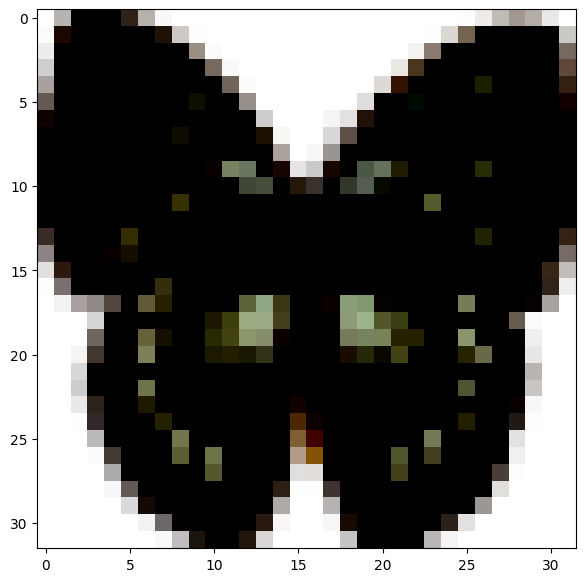

In [ ]:
clean_images0 = clean_images[0]

clean_images0 = clean_images0.detach().cpu().numpy()

plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(clean_images0, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

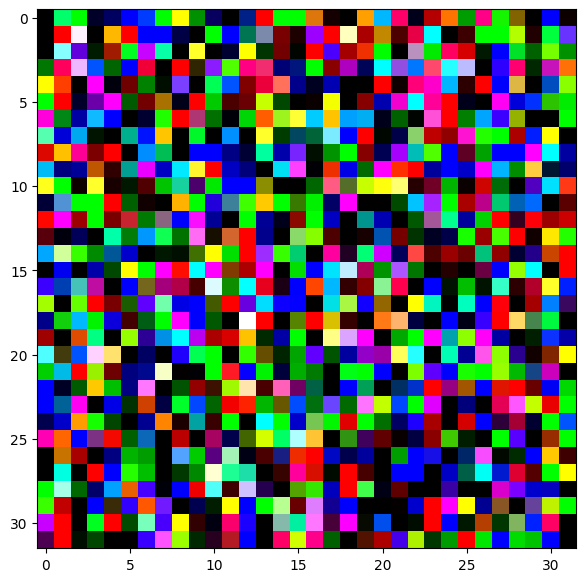

In [ ]:
noise0 = noise[0]

noise0 = noise0.detach().cpu().numpy()

plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(noise0, (1, 2, 0)))  # Transpose to (32, 32, 3) for RGB images
plt.show()

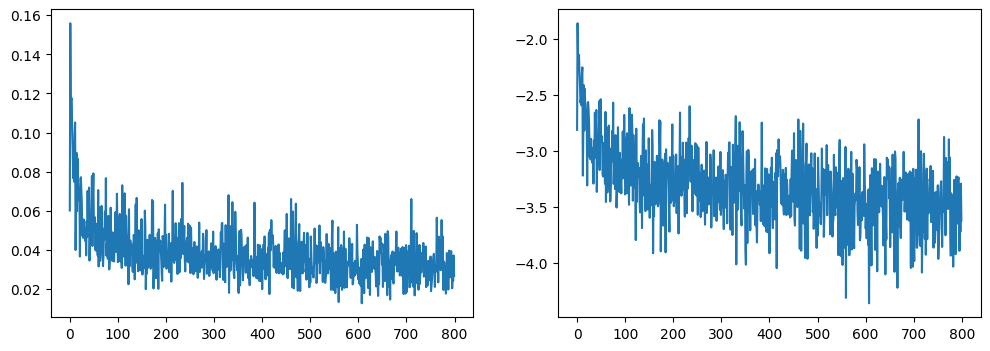

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

# Generate Images

2 ways are there
- Creating a pipeline - `DDPMPipeline()`
- Writing a sample loop

## Creating a pipeline

  0%|          | 0/1000 [00:00<?, ?it/s]

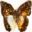

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet = model, scheduler = noise_scheduler)

pipeline_op = image_pipe()

pipeline_op.images[0]

## Writing sample loop

- Starting with random noise and generating an image

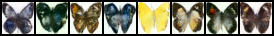

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

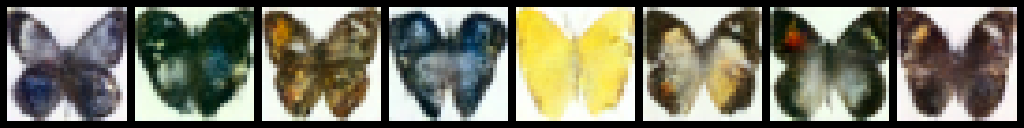

In [ ]:
show_images(sample).resize((8*128,128), resample = Image.NEAREST)